In [1]:
#bulk RNAseq perfusion
setwd("~/ben_lustre/current_projects/kidney_glomTI_response")
suppressPackageStartupMessages(source("https://raw.githubusercontent.com/bjstewart1/helpful_singlecell/main/functions.R"))
ad <- import("anndata")
sc <- import("scanpy")
clean_theme <- theme_bw() + theme(axis.text = element_text(color = "black"), axis.title = element_text(color = "black"))
library(ggplot2)

Warning message:
“The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


In [2]:
sequencing_inventory <- read.csv("~/ben_nfs/sample_donor_data/sequencing_inventory.csv")
bulk_donors <- sequencing_inventory[sequencing_inventory$experiment %in%  "bulk_RNA_seq", ]
bulk_donors= bulk_donors[bulk_donors$submission_channel %in% 'bulk_kidney_cortex', ]
channels = bulk_donors$sanger_ID

In [3]:
#read in counts
tab = read.table("./data/seq_data/bulk_RNAseq/results-study6642-tic1844/combined/study6642-tic1844-star-genecounts.txt",
                header = TRUE, row.names = 1)
counts = tab
counts = counts[rownames(counts) %in% grep("ENSG*", rownames(counts), value = TRUE), ]
counts = counts[, channels]
#remove ERCC and other elements that we don't want
saveRDS(counts, "./data/seq_data/bulk_RNAseq/bulk_perfusion_cortex_counts.RDS")

In [4]:
#annotate genes
library(biomaRt)
ensembl <- useEnsembl(biomart = "genes", dataset = "hsapiens_gene_ensembl")
gene_symbols = getBM(attributes = c('ensembl_gene_id', 'external_gene_name', 'gene_biotype'),
      filters = 'ensembl_gene_id',
      values = rownames(counts), 
      mart = ensembl)
gene_symbols = data.frame(gene_symbols, row.names = 1)
annotation = data.frame("feature" = rownames(counts), gene_symbols[rownames(counts), ])
colnames(annotation) = c("ID", "Symbol", "biotype")

In [5]:
stimulation = c("K281" = "IC", "K282" = "IC", "K283" = "control", 
               "K287" = "IC", "K288" = "control", "K289" = "IC", "K290" = "control")
donor_mapping = c("K281" = "donor1", "K282" = "donor2", "K283" = "donor2",
                  "K287" = "donor3", "K288" = "donor3", "K289" = "donor4", "K290" = "donor4")
metadata <- bulk_donors
metadata = do.call(rbind, lapply(strsplit( metadata$sequencing_sample_name, "-"), 
       function(x){data.frame("donor" = x[1], 'timepoint' = gsub("T", "", x[2]))}))
metadata$stimulation = stimulation[metadata$donor]
metadata$kidney_pair = donor_mapping[metadata$donor]

In [6]:
metadata

donor,timepoint,stimulation,kidney_pair
<chr>,<chr>,<chr>,<chr>
K288,4,control,donor3
K288,2,control,donor3
K287,4,IC,donor3
K287,0,IC,donor3
K287,2,IC,donor3
K288,0,control,donor3
K281,4,IC,donor1
K281,2,IC,donor1
K281,0,IC,donor1


In [7]:
annotation = annotation[rownames(counts), ]
colnames(counts) = NULL
rownames(counts) = NULL

In [183]:
#timepoint DE
library(DESeq2)
dds <- DESeqDataSetFromMatrix(countData = counts,
                              colData = metadata,
                              rowData = annotation,
                             design = ~stimulation)
#subset to protein coding genes
dds = dds[rowData(dds)$biotype %in% "protein_coding", ]
dds = dds[!rowData(dds)$Symbol %in% "", ] #get the symbols with names
keep <- rowSums(counts(dds)) > 10
dds <- dds[keep,]
dds <- DESeq(dds)
gene_expr <- vst(dds, blind=FALSE)
res <- results(dds)
res$Symbol <- rowData(dds)[rownames(res), "Symbol"]
res <- res[!is.na(res$padj), ]
res$significant <- ifelse(res$padj < 0.05 & abs(res$log2FoldChange) > 1, "significant", "nonsignificant"

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 431 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



In [210]:
library(DESeq2)
dds <- DESeqDataSetFromMatrix(countData = counts[, metadata$stimulation %in% 'control'],
                              colData = metadata[metadata$stimulation %in% 'control',],
                              rowData = annotation,
                             design = ~kidney_pair+timepoint)
#subset to protein coding genes
dds = dds[rowData(dds)$biotype %in% "protein_coding", ]
dds = dds[!rowData(dds)$Symbol %in% "", ] #get the symbols with names
keep <- rowSums(counts(dds)) > 10
dds <- dds[keep,]
dds <- DESeq(dds)
gene_expr <- vst(dds, blind=FALSE)
res <- results(dds)
res$Symbol <- rowData(dds)[rownames(res), "Symbol"]
res <- res[!is.na(res$padj), ]
res$significant <- ifelse(res$padj < 0.01 & abs(res$log2FoldChange) > 2, "significant", "nonsignificant")

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [216]:
res = res[order(res$stat, decreasing = TRUE), ]
head(data.frame(res), 30)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Symbol,significant
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
ENSG00000128591,1494.46849,4.050151,0.3007096,13.468645,2.392145e-41,3.556641e-37,FLNC,significant
ENSG00000175793,434.42983,5.337946,0.4096559,13.030318,8.226413e-39,6.115515e-35,SFN,significant
ENSG00000058085,782.57653,3.438273,0.2925491,11.752807,6.831124e-32,3.385505e-28,LAMC2,significant
ENSG00000162413,2033.11242,2.465111,0.2305072,10.694292,1.082436e-26,4.023416e-23,KLHL21,significant
ENSG00000101255,252.09038,4.287990,0.4041045,10.611092,2.646383e-26,7.869285e-23,TRIB3,significant
ENSG00000196878,931.63796,3.332082,0.3195466,10.427529,1.856530e-25,4.600482e-22,LAMB3,significant
ENSG00000163661,930.68239,6.741222,0.6599567,10.214642,1.705081e-24,3.621592e-21,PTX3,significant
ENSG00000160712,1778.80954,2.077769,0.2363419,8.791369,1.477482e-18,2.745901e-15,IL6R,significant
ENSG00000196182,1693.86704,1.970812,0.2272974,8.670631,4.297324e-18,7.099179e-15,STK40,nonsignificant


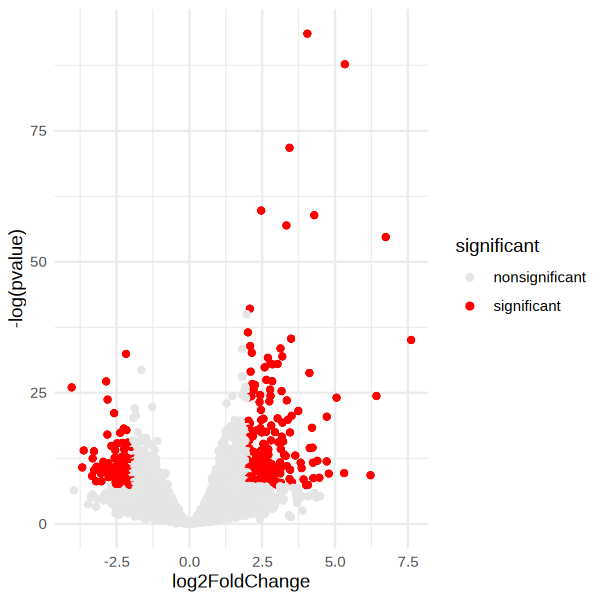

In [212]:
ggplot(data.frame(res), aes(x = log2FoldChange, y = -log(pvalue), color = significant)) + ggrastr::geom_point_rast(pch=19) + 
           scale_color_manual(values = c("significant" = 'red', "nonsignificant" = 'grey90'))  + theme_minimal()

In [218]:
gene_expr

class: DESeqTransform 
dim: 16118 9 
metadata(1): version
assays(1): ''
rownames(16118): ENSG00000000003 ENSG00000000005 ... ENSG00000284713
  ENSG00000284730
rowData names(37): ID Symbol ... maxCooks dispFit
colnames(9): 1 2 ... 8 9
colData names(5): donor timepoint stimulation kidney_pair sizeFactor

In [213]:
library(msigdbr)
t2g= msigdbr(species = 'Homo sapiens', category = "H")[, c('gs_name', 'gene_symbol')]
colnames(t2g) = c('TERM', 'GENE')

In [214]:
geneList = res$stat
names(geneList) = res$Symbol
geneList = geneList[order(geneList, decreasing = TRUE)]
enrichment_result <- GSEA(geneList, TERM2GENE = t2g, pvalueCutoff = 1)    
enr_df = enrichment_result@result

preparing geneSet collections...

GSEA analysis...

Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
“For some pathways, in reality P-values are less than 1e-10. You can set the `eps` argument to zero for better estimation.”
leading edge analysis...

done...



In [10]:
#now we do differential expression for each timepoint.
de_results = lapply(c(0, 2, 4), function(tp){
    message(paste0('timepoint ', tp))
    dds_use <- DESeqDataSetFromMatrix(countData = counts,
                              colData = metadata,
                              rowData = annotation,
                             design = ~kidney_pair + stimulation)
    #subset to protein coding genes
    dds_use = dds_use[rowData(dds_use)$biotype %in% "protein_coding", ]
    dds_use = dds_use[!rowData(dds_use)$Symbol %in% "", ] #get the symbols with names
    subdds = dds_use[, colData(dds_use)$timepoint == tp]
    keep <- rowSums(counts(subdds)) > 10
    subdds <- subdds[keep,]
    subdds <- DESeq(subdds)
    res <- results(subdds)
    res$Symbol <- rowData(subdds)[rownames(res), "Symbol"]
    res <- res[!is.na(res$padj), ]
    res$significant <- ifelse(res$pvalue < 0.05 & abs(res$log2FoldChange) > 1, "significant", "nonsignificant")
    return(res)
})
names(de_results) = c(0,2,4)

timepoint 0

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

timepoint 2

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

timepoint 4

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [11]:
volcano_input = do.call(rbind, lapply(names(de_results), function(tp){
    de = data.frame(de_results[[tp]], 'timepoint' = tp)
    symbols = de[de$significant == 'significant' & de$log2FoldChange > 0, 'Symbol' ]
    de$label = de$Symbol
    de$label[!de$Symbol %in% symbols] = NA
return(de)
}))

In [12]:
options(repr.plot.width = 20, repr.plot.height = 7)
volcano_plots = ggplot(volcano_input, aes(x = log2FoldChange, y = -log(pvalue), label = label, color = significant)) + ggrastr::geom_point_rast(pch=19) + facet_wrap(~timepoint) + 
           scale_color_manual(values = c("significant" = 'red', "nonsignificant" = 'grey90')) + geom_label() + theme_minimal()

Warning message:
“Removed 47293 rows containing missing values (`geom_label()`).”


png 
  2

Warning message:
“Removed 47293 rows containing missing values (`geom_label()`).”


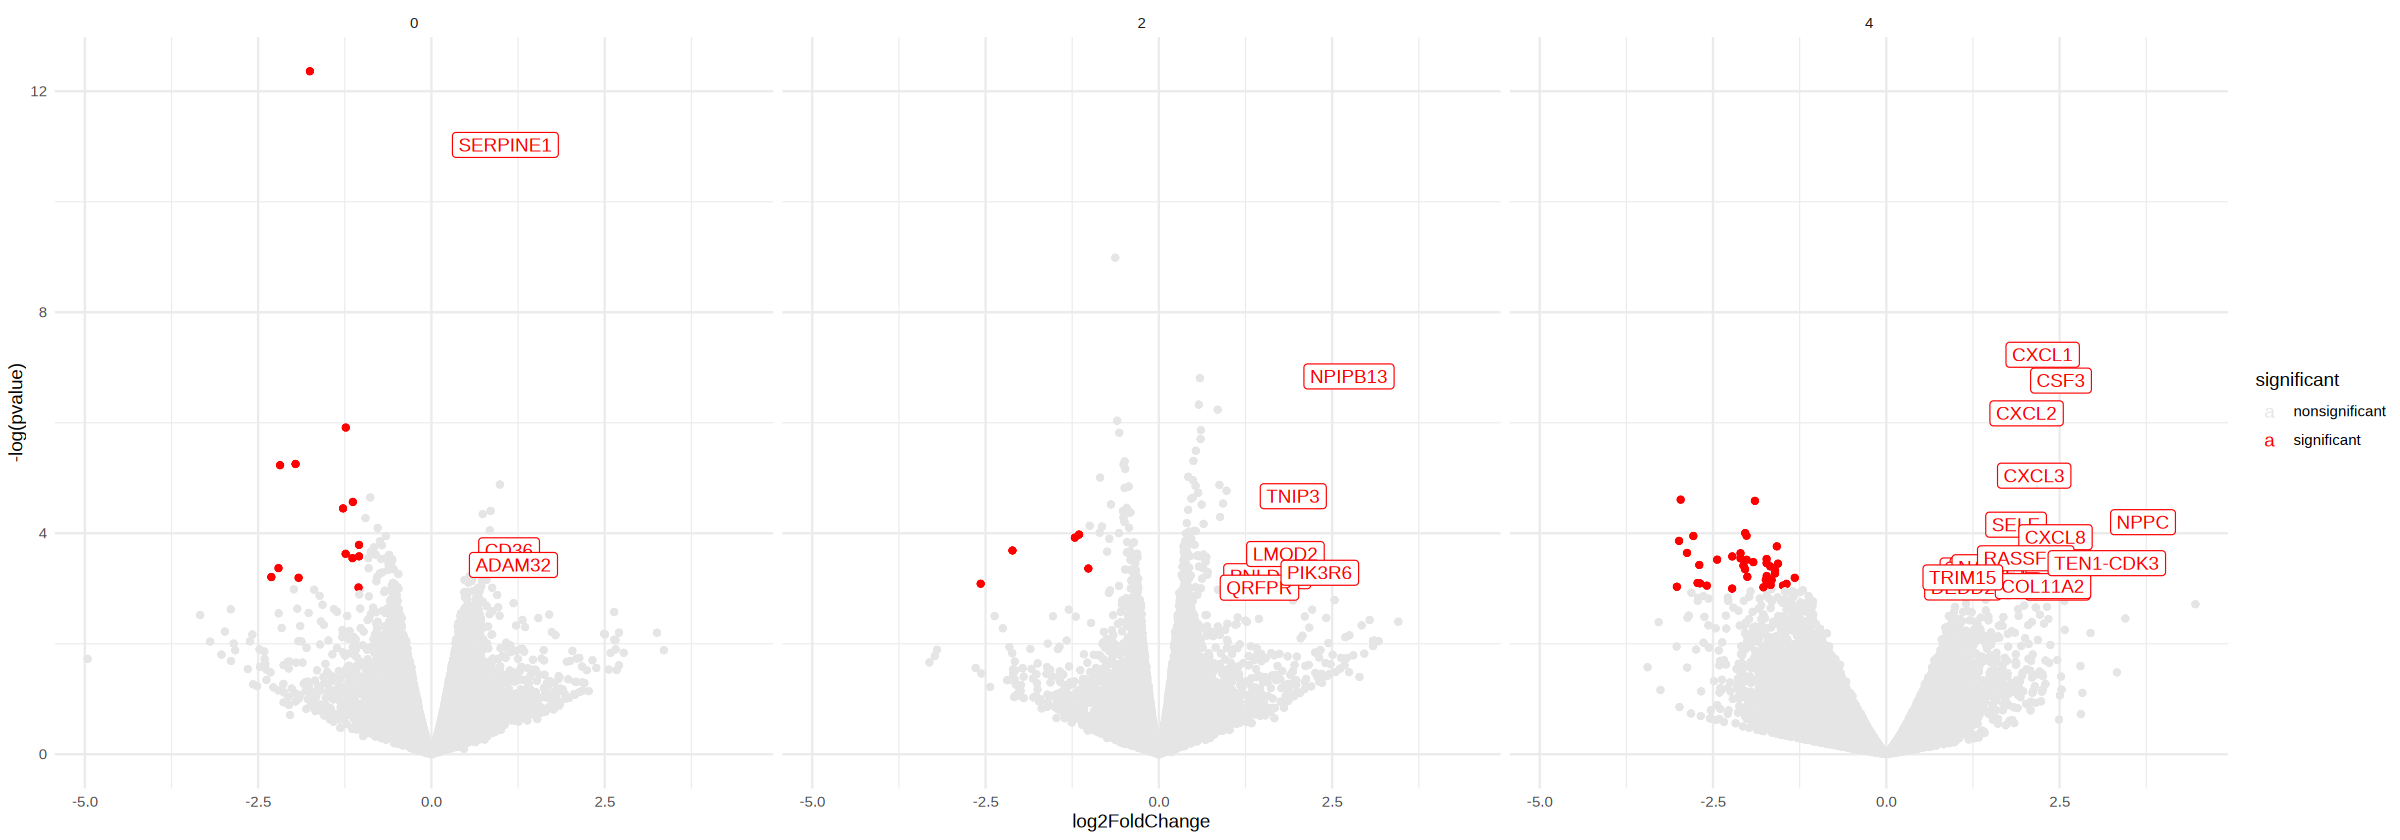

In [13]:
pdf('./figures/bulk_perfusion_sequencing_volcanos.pdf', width = 22, height = 7)
volcano_plots
dev.off()
volcano_plots

In [14]:
#what is the intersection between the GEC signature and the bulk response signature
gec_signature =read.csv("./data/da_results/perfusion/response_signatures/GEC_response_geneset.csv")$X
bulk_response = volcano_input[volcano_input$significant == 'significant' & volcano_input$timepoint == '4' &  volcano_input$stat > 0, 'Symbol']
intersect(gec_signature, bulk_response)

[1] "CXCL3" "SELE"  "IL6"   "CSF3"  "CXCL8" "CXCL2" "CXCL1"

In [15]:
#now get the response signatures and look for enrichment at each timepoint
library(clusterProfiler)
t2g = do.call(rbind, lapply(c("classical_monocyte", "NK1", "GEC"), function(ct){
    fp = file.path("./data/da_results/perfusion/response_signatures", paste0(ct, "_response_geneset.csv"))
    signature =read.csv(fp)$X
    df = data.frame("TERM" = ct, "GENE" = signature)
    return(df)
}))
enrichments = do.call(rbind, lapply(c('0', '2', '4'), function(tp){
de = volcano_input[volcano_input$timepoint == tp,]
geneList = de$stat
names(geneList) = de$Symbol
geneList = geneList[order(geneList, decreasing = TRUE)]
enrichment_result <- GSEA(geneList, TERM2GENE = t2g, pvalueCutoff = 1)    
enr_df = data.frame(enrichment_result@result, 'timepoint' = tp)
    return(enr_df)
}))




Registered S3 methods overwritten by 'treeio':
  method              from    
  MRCA.phylo          tidytree
  MRCA.treedata       tidytree
  Nnode.treedata      tidytree
  Ntip.treedata       tidytree
  ancestor.phylo      tidytree
  ancestor.treedata   tidytree
  child.phylo         tidytree
  child.treedata      tidytree
  full_join.phylo     tidytree
  full_join.treedata  tidytree
  groupClade.phylo    tidytree
  groupClade.treedata tidytree
  groupOTU.phylo      tidytree
  groupOTU.treedata   tidytree
  is.rooted.treedata  tidytree
  nodeid.phylo        tidytree
  nodeid.treedata     tidytree
  nodelab.phylo       tidytree
  nodelab.treedata    tidytree
  offspring.phylo     tidytree
  offspring.treedata  tidytree
  parent.phylo        tidytree
  parent.treedata     tidytree
  root.treedata       tidytree
  rootnode.phylo      tidytree
  sibling.phylo       tidytree

clusterProfiler v4.6.2  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use clusterProf

In [16]:
options(repr.plot.width = 5, repr.plot.height = 5)
enrichments$p.adjust[enrichments$p.adjust >0.05] = NA
enrichment_gsea = ggplot(enrichments, aes(x = NES, y = ID, size = -log(p.adjust), fill = -log(p.adjust))) + geom_point(pch=21) + facet_wrap(~timepoint, ncol =1) + 
scale_fill_gradientn(colors = viridis::cividis(100))
pdf('./figures/perfusion_bulk_GSEA.pdf')
enrichment_gsea
dev.off()

Warning message:
“Removed 3 rows containing missing values (`geom_point()`).”


png 
  2